<a href="https://colab.research.google.com/github/adrianrdz8/GaussianHMM/blob/master/GHMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gaussian Hidden Markov Model
This is a project from the class of Methods of Classification and Dimensionality reduction from the University of Wroclaw

##Installing necessary modules

In [1]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
from collections import Counter
from collections import defaultdict
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import mixture
import csv
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse 

## Data downloading

In [3]:
with open('data_public.csv', 'r') as csv_file:
    data = list(csv.reader(csv_file, delimiter=';'))

In [4]:
df = pd.DataFrame(data)
df = df.set_index(0)
n, p = df.shape

In [5]:
all_vals = df.values.astype(float).tolist()

In [6]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498
0,,,,,,,,,,,,,,,,,,,,,
0,17.440426893012674,18.698026837176727,-1.0501366808961374,18.84617923917562,-0.5236423103271073,-3.1877514710475774,20.23935137711991,19.547900429144796,0.46503522579027523,-1.8922662318333017,...,None,None,None,None,None,None,None,None,None,None
1,7.690539833190373,6.812853471572357,8.06143321362935,8.089214707726175,0.41513628627972754,7.929586363993851,7.812755525160936,8.920244418122266,1.4637320314089075,8.46760061503703,...,None,None,None,None,None,None,None,None,None,None
2,1.5533805597145094,7.562209964406401,7.164539067673536,1.9860303523119833,1.9767153650986846,1.767606281348555,10.036525367691562,10.188470489518911,16.162713684132974,8.550819206308915,...,None,None,None,None,None,None,None,None,None,None
3,16.965469413034114,18.749013254353006,0.9787293027789921,-1.2764620297518323,17.37039274918025,-3.3338324485948636,17.81489196063149,-0.7312644870857037,17.313577935623968,18.187884383536076,...,None,None,None,None,None,None,None,None,None,None
4,20.888769092216805,19.025386904831883,19.28509130547773,19.67006717124081,20.615855592287446,20.801112852472947,18.202574166516456,20.082696060778805,20.141571717899307,6.086688983356466,...,None,None,None,None,None,None,None,None,None,None


Dataset contains 2000 rows with different number of columns. Each row represents a series of numbers.

##Data cleaning and NAN removing

In [8]:
nans_num = [sum([math.isnan(x) for x in all_vals[i]]) for i in range(n)]

In [9]:
# all pos without nans
element_len = {}
min_len = p
min_len_loc = 0
for i in range(n):
    all_vals[i] = all_vals[i][0:p-nans_num[i]]
    element_len[i] = len(all_vals[i])
    if len(all_vals[i]) < min_len:
        min_len = len(all_vals[i])
        min_len_loc = i
print('Columns were updated with correct number of values')
print(f'The row with less numbers is # {min_len_loc} with {min_len} elements.')

Columns were updated with correct number of values
The row with less numbers is # 88 with 999 elements.


In [10]:
nan_test = sum([sum([math.isnan(x) for x in all_vals[i]]) for i in range(n)])
if nan_test == 0:
    print('All nan values were located at the end of every row.')

All nan values were located at the end of every row.


In order to test the model with RMSE, I removed the last number of the serie. This number will be predicted using GHMM.

In [11]:
correct_values = [all_vals[i][-1] for i in range(len(all_vals))]

In [ ]:
[all_vals[i].pop() for i in range(len(all_vals))]

##Data analysis

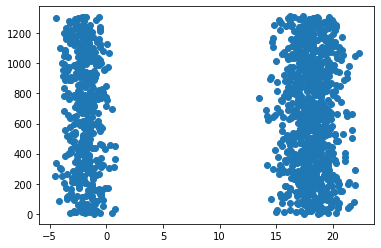

In [13]:
data_plt = [float(i) for i in all_vals[0]]
plt.scatter(data_plt, range(len(data_plt)))

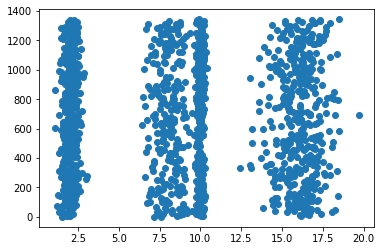

In [14]:
data_plt = [float(i) for i in all_vals[2]]
plt.scatter(data_plt, range(len(data_plt)))

We observe in above image that numbers from each column are divided into clusters. Next step is to analyize the number of clusters per each row using Bayesian Information Criteria (BIC) to identify the best number of clusters for the data.

In [186]:
bv = []
for i in range(len(all_vals)):
    low_bic = []
    for n_comp in range(2,5):
        X = np.array(all_vals[i]).reshape(-1,1)
        gmm = mixture.GaussianMixture(n_components=n_comp)
        gmm.fit(X)
        low_bic.append(gmm.bic(X))
    best_comp = low_bic.index(min(low_bic)) + 2
    bv.append(best_comp)

## Applying Gaussian Hidden Markov Model

Here, I decided to test 2 different methods:
1. **Random value** generated from the proposed new state from the Gaussian Markov Model.
2. **Mean** of all the values of the new state proposed from the Gaussian Markov Model.

In [187]:
def random_value(model, next_state_pred):
    new_value_state = model.sample(n_samples=1, currstate=next_state_pred)
    pred_value = new_value_state[0][0][0]
    next_states_value = new_value_state[1][0]
    return pred_value, next_states_value

In [188]:
def mean_value(all_vals, all_means, next_states):
    # Getting all means
    final_pred = [all_means[i][next_states[i]] for i in range(len(all_vals))]
    return final_pred

In [ ]:
next_states = []
next_states_1 = []
all_preds = []
final_pred_1 = []
matrices = []
for i in range(len(all_vals)):
    # Generating X for each row
    X = all_vals[i]
    X = np.array(X)
    X = X.reshape(-1,1)

    # Creating the model and fitting it to the data
    model = hmm.GaussianHMM(bv[i])
    model.fit(X)

    # Get the sequence of states
    pred_vals = model.predict(X)
    all_preds.append(pred_vals)

    # Get all the transition matrices
    tran_matrix = model.transmat_
    matrices.append(tran_matrix)

    # Predict next state based on the state with highest probability 
    # in the transition matrix
    next_state_pred = np.argmax(tran_matrix[pred_vals[-1]])
    next_states.append(next_state_pred)

    # Predict next value based on a random number from the next distribution
    pred_1, next_state_1 = random_value(model, next_state_pred)
    final_pred_1.append(pred_1)
    next_states_1.append(next_state_1)

# Predict next value based on the mean of the next distribution
all_means = [[(np.mean([all_vals[k][i] for i in range(len(all_vals[k])) if all_preds[k][i] == j])) for j in range(bv[k])] for k in range(len(all_vals))]
# Removing nan values from all means of the rows
nan_means = [(i, j) for i in range(len(all_vals)) for j in range(bv[i]) if math.isnan(all_means[i][j])]
for i in range(len(nan_means)):
    all_means[nan_means[i][0]][nan_means[i][1]] = 0
final_pred_2 = mean_value(all_vals, all_means, next_states)

## Testing results with RMSE

In order to test the results, Root Mean Squared Error (RMSE) was utilized:
\begin{align}
RMSE = \sqrt{\frac{1}{R}\sum_{i=0}^{R-1}{(y_i-y_{est}})^2}
\end{align}

In [195]:
def rmse(correct_values, prediction):
    val = np.sqrt(np.sum(np.subtract(correct_values,prediction)**2) * (1/n))
    return val

In [196]:
rmse(correct_values, final_pred_1)

8.263501531823577

In [197]:
rmse(correct_values, final_pred_2)

8.222845128249196

After getting RMSE for both methods, there is not a representative difference between them. They have very similar RMSE.

## New (And best) approach

In order to reduce RMSE, instead of utilizing the **Mean** I decided to utilize the **Weighted Mean** by weighting all the means of each row depending on the probabilities from the actual state given by the transition matrix.

In [198]:
def weighted_mean(all_means, matrices, all_preds, all_vals):
    wm = [np.sum(np.multiply(matrices[i][all_preds[i][-1]],all_means[i])) for i in range(len(all_vals))]
    return wm

In [199]:
final_pred_3 = weighted_mean(all_means, matrices, all_preds, all_vals)

In [200]:
rmse(correct_values, final_pred_3)

6.316159730861374